In [1]:
import random

In [2]:
random_seed = 10
random.seed(random_seed)

In [3]:
%pip install swifter
%pip install python-dotenv
%pip install bertopic
%pip install tensorflow
%pip install sentence-transformers
%pip install gensim

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import plotly.express as px
import matplotlib.pyplot as plt

from datetime import datetime
import logging
import os
import sys
import time
import re

from dotenv import load_dotenv
#import openai
import swifter
from sentence_transformers import SentenceTransformer


from bertopic import BERTopic
import joblib
from sklearn.preprocessing import normalize
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
#shared drive version at everyone can set up
df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/palm_oil_grievance_logs.csv')
df.head(5)

,pk,source,internal_id,status,submitted_on,accepted_on,last_updated_on,country,region,complainants,respondents,respondent_sector,respondent_parent_company,respondent_supplier,summary,history,external_link,extras
0,1,Roundtable on Sustainable Palm Oil (RSPO),500Mg00000L0di6IAB,Closed,2/26/2025,4/15/2025,5/20/2025,Indonesia,Sumatera Selatan,Confidential,PT Sawit Mas Sejahtera,Oil Palm Growers,Golden Agri-Resources (GAR),NaN,That the Respondent allegedly transferred the ...,2025-05-20: CP's Decision Letter dated 20. 05....,https://rspo.my.site.com/Complaint/s/case/500M...,{'case_number': 'RSPO/2025/02/RR'}
1,2,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVwYqYAK,In Progress - Investigation,11/29/2024,1/16/2025,1/16/2025,Mexico,NaN,Confidential,INDUSTRIAS OLEOPALMA S.A. DE C.V.,Oil Palm Growers,Oleoquímica Mexicana S.A. de C.V.,NaN,The Complainant alleges that the Respondent ha...,2025-04-30: The Secretariat furnished the Resp...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/17/MAM'}
2,3,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVxmPYAS,In Progress - Investigation,11/28/2024,1/21/2025,1/21/2025,Colombia,Montes de María,Confidential,OLEOFLORES S A S,Processors and/or Traders,Musim Mas Holdings Pte.,NaN,1.The Complainant alleges that the Respondent ...,2025-04-30: The Complaints Panels directive to...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/18/HN'}
3,4,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVGg2YAG,In Progress - Investigation,10/16/2024,11/18/2024,11/18/2024,Indonesia,Riau,S. Samsul Hadi,PT Guntung Idamannusa,Oil Palm Growers,Compañía Industrial Aceitera Coto Cincuenta y ...,NaN,The Respondent's Corporate Social Responsibili...,2025-04-30: The Complaints Panel has directed ...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/14/RH'}
4,5,Roundtable on Sustainable Palm Oil (RSPO),500GB00003vMwFgYAK,In Progress - Investigation,9/11/2024,10/29/2024,10/29/2024,Costa Rica,Pococi/Limón,Confidential,Compañía Palma Tica S.A.,Oil Palm Growers,NaN,NaN,The Complainant alleges that the Respondent br...,2025-04-30: The Briefing Note is in progress. ...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/13/MAM'}


## Preprocessing

In [7]:
#stop words, lower case, and remove punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# preprocessing function
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    # Use regular expression to replace all punctuation with a space
    text = re.sub(f'[{re.escape("".join(punctuation))}]', ' ', text)
    tokens = text.split()
    # Removed the strip() call as regex handles punctuation removal
    # tokens = [word.strip("".join(punctuation)) for word in tokens]
    tokens = [word for word in tokens if word and word not in stop_words]

    return tokens

# Add cleaned tokens to the df
df["tokens"] = df["summary"].apply(clean_text)

# Define the list of words to filter out
words_to_filter = {'nan', 'pt','report','rspo','alleged', 'palm', 'oil', 'company', 'community', 'complainant',
                   'companies', 'also', 'without', 'group', 'allegedly', 'period', 'respondent', 'reported',
                   'mentioned', '2019', '19', '2020', 'subsidary', 'alleges'}

# filter out words that we think are not helpful
df['flt_tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in words_to_filter])


df['flt_tokens'] = df['flt_tokens'].apply(lambda x: ' '.join(x))

## Embedding

In [8]:
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s', level=logging.INFO)

BATCH_SIZE = 100
output_dir = "../data/intermediate"
os.makedirs(output_dir, exist_ok=True)

# load model once
model = SentenceTransformer('all-MiniLM-L6-v2')

# define embedding function
def get_embedding(text) -> list:
    if not text:
        return None
    try:
        return model.encode(text)
    except Exception as e:
        logging.error(f"Error getting embedding for text: {str(text)[:50]}... Error: {e}")
        return None

# main batch embedding function
def run_local_embeddings():
    formatted_datetime = datetime.now().strftime("%d_%b_%Y_%H_%M_%S")
    n = len(df)

    if 'embedding' not in df.columns:
        df['embedding'] = None

    df_start = 0
    while df_start < n:
        df_intermediate = df[df_start:df_start + BATCH_SIZE].copy()

        # Only process rows that do NOT have numpy array embeddings yet
        df_intermediate_unprocessed = df_intermediate.loc[
            df_intermediate['embedding'].apply(lambda x: not isinstance(x, np.ndarray))
        ]
        unprocessed_rows = len(df_intermediate_unprocessed)

        if unprocessed_rows == 0:
            logging.info(f"No unprocessed rows in batch starting at {df_start}")
        else:
            logging.info(f"Running embeddings on {unprocessed_rows} rows in batch starting at {df_start}")
            try:
                df_intermediate_unprocessed["embedding"] = df_intermediate_unprocessed["flt_tokens"].swifter.apply(
                    get_embedding
                )

                successful = df_intermediate_unprocessed.loc[
                    df_intermediate_unprocessed['embedding'].apply(lambda x: isinstance(x, np.ndarray))
                ]
                df.loc[successful.index, 'embedding'] = successful['embedding']

            except Exception as exc:
                logging.exception(f"Exception during embedding: {exc}")

        # save partial batch
        df.to_pickle(f"{output_dir}/embeddings_partial_{df_start}_{formatted_datetime}.pkl")
        df_start += BATCH_SIZE

    # save full dataset
    df.to_pickle(f"{output_dir}/embeddings_full_{formatted_datetime}.pkl")
    logging.info("Finished all batches and saved full dataset.")

run_local_embeddings()

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

## Model Creation

In [9]:
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [10]:
%pip install scikit-fuzzy

In [11]:
from skfuzzy.cluster import cmeans
from sentence_transformers import SentenceTransformer
import umap
import numpy as np

In [12]:
# # Define Clustering Models
# soft_kmeans_model = GaussianMixture(n_components=20, random_state=42)
class FuzzyCMeansModel:
    def __init__(self, n_clusters=10, m=2, error=0.005, maxiter=1000):
        self.n_clusters = n_clusters
        self.m = m
        self.error = error
        self.maxiter = maxiter
        self.labels_ = None
        self.centers = None
        self.u = None  # Membership matrix

    def fit(self, X):
        self.centers, self.u, _, _, _, _, _ = cmeans(
            X.T, self.n_clusters, self.m, error=self.error, maxiter=self.maxiter
        )
        self.labels_ = np.argmax(self.u, axis=0)
        return self

    def predict(self, X):
        return self.labels_

In [13]:
## bertopic.py ##

# Filter out rows where the 'embedding' is None
df_embeddings = df.dropna(subset=['embedding']).copy()

# Normalize embeddings and store them in a new column
df_embeddings['embedding_normalized'] = df_embeddings['embedding'].apply(
  lambda x: normalize([x], norm='l2')[0]
)
embeddings_array = np.array(df_embeddings['embedding_normalized'].tolist())

# Use the cleaned text for docs
docs = df_embeddings['flt_tokens'].tolist()

# Initialize BERTopic model with a random_state for reproducibility

cluster_model = FuzzyCMeansModel(n_clusters= 6)
bertopic_model = BERTopic(hdbscan_model=cluster_model)

# Fit model
topics, probs = bertopic_model.fit_transform(docs, embeddings_array)

#fix for indexing, store the actual topic ids assigned by bert
df_embeddings["bertopic_topic"] = topics
df_embeddings["bertopic_prob"] = probs

# Get actual fuzzy topic probabilities from the Fuzzy C-Means model
membership_probs = cluster_model.u.T  # shape = (n_docs, n_topics)

# Turn it into a DataFrame
membership_df = pd.DataFrame(membership_probs, columns=[f"Topic_{i}" for i in range(cluster_model.n_clusters)])

# Join with df_embeddings
df_embeddings = df_embeddings.reset_index(drop=True)
df_embeddings = pd.concat([df_embeddings, membership_df], axis=1)

# Now you can access per-topic probabilities per document
df_embeddings.head()

df_embeddings["topic"] = membership_df.idxmax(axis=1).apply(lambda x: int(x.split("_")[1]))
df_embeddings["probs"] = membership_df.max(axis=1)


# Print the topics and their top words after fitting the model
print("BERTopic Topics and Top Words:")
print(bertopic_model.get_topics())

# Get the current datetime for the filename
formatted_datetime = datetime.now().strftime("%d_%b_%Y_%H_%M_%S")

# Create the output directory for embeddings if it doesn't exist
output_embeddings_dir = "../data/embeddings"
os.makedirs(output_embeddings_dir, exist_ok=True)

# Save dataframe with topics and probabilities
df_embeddings.to_csv(
  f"{output_embeddings_dir}/feedback_embeddings_bertopic_{formatted_datetime}.csv",
  index=False
)

# Create the output directory for models if it doesn't exist
output_models_dir = "../models"
os.makedirs(output_models_dir, exist_ok=True)

# save the model for future use on unseen data
joblib.dump(
  bertopic_model,
  f"{output_models_dir}/bertopic_model_{formatted_datetime}.joblib"
)

print("BERTopic model worked.")

BERTopic Topics and Top Words:
{0: [('land', 0.11132078534504795), ('communities', 0.03696619319062304), ('local', 0.03214358863041673), ('allegations', 0.029326084757709266), ('plasma', 0.027716804944133495), ('complaint', 0.026475150949477895), ('rights', 0.024943768141227996), ('process', 0.02317325526929884), ('informed', 0.022363797612523006), ('hcv', 0.020776806320139375)], 1: [('earth', 0.09242341120152743), ('mighty', 0.09167043118268377), ('ha', 0.08993026787075394), ('rapid', 0.08793436112099513), ('concession', 0.08164531314294439), ('response', 0.08153425151451686), ('deforestation', 0.07705854054876618), ('indications', 0.06483830283493038), ('forest', 0.059515319127970034), ('cleared', 0.05624742087722141)], 2: [('forest', 0.023058502658548398), ('river', 0.02186466307890116), ('land', 0.019599975900373785), ('area', 0.01863587837199807), ('hcv', 0.01833125081383863), ('principle', 0.01793713065981996), ('sustainable', 0.017849154761966798), ('plantation', 0.0173106280377

In [14]:
membership_df

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,0.992487,0.002966,0.000570,0.001894,0.001212,0.000871
1,0.988526,0.004424,0.000904,0.002903,0.001875,0.001368
2,0.019320,0.660465,0.010155,0.243945,0.046238,0.019877
3,0.017127,0.146958,0.011618,0.591678,0.208323,0.024296
4,0.018535,0.253950,0.014081,0.577675,0.109055,0.026704
...,...,...,...,...,...,...
382,0.140756,0.566833,0.019564,0.168378,0.070041,0.034428
383,0.025384,0.162014,0.021666,0.490424,0.250802,0.049710
384,0.016439,0.035135,0.578433,0.051827,0.048150,0.270015
385,0.027451,0.058653,0.432972,0.086785,0.091648,0.302491


In [15]:
df_embeddings['probs']

,probs
0,0.992487
1,0.988526
2,0.660465
3,0.591678
4,0.577675
...,...
382,0.566833
383,0.490424
384,0.578433
385,0.432972


In [16]:
print(bertopic_model.get_topic_info())

   Topic  Count                                  Name  \
0      0     85  0_land_communities_local_allegations   
1      1     81               1_earth_mighty_ha_rapid   
2      2     74              2_forest_river_land_area   
3      3     54             3_eof_forest_mill_illegal   
4      4     50     4_workers_labour_union_employment   
5      5     43      5_gar_deforestation_linked_chain   

                                      Representation  \
0  [land, communities, local, allegations, plasma...   
1  [earth, mighty, ha, rapid, concession, respons...   
2  [forest, river, land, area, hcv, principle, su...   
3  [eof, forest, mill, illegal, gar, plantation, ...   
4  [workers, labour, union, employment, casual, d...   
5  [gar, deforestation, linked, chain, jaya, supp...   

                                 Representative_Docs  
0  [new planting announcement wilmar affect commu...  
1  [mighty earth rapid response indications 21 ha...  
2  [points raised npp published challengin

## Raw Output

In [17]:
# Get the topic information DataFrame
topic_info_df = bertopic_model.get_topic_info()

#print(topic_info_df['Representation'])
# Iterate through the 'Representation' column and print each list of words
for index, representation in topic_info_df['Representation'].items():
    topic_id = topic_info_df.loc[index, 'Topic'] # Get the corresponding Topic ID
    print(f"Topic {topic_id} Representation: {representation}")

Topic 0 Representation: ['land', 'communities', 'local', 'allegations', 'plasma', 'complaint', 'rights', 'process', 'informed', 'hcv']
Topic 1 Representation: ['earth', 'mighty', 'ha', 'rapid', 'concession', 'response', 'deforestation', 'indications', 'forest', 'cleared']
Topic 2 Representation: ['forest', 'river', 'land', 'area', 'hcv', 'principle', 'sustainable', 'plantation', 'rspos', 'water']
Topic 3 Representation: ['eof', 'forest', 'mill', 'illegal', 'gar', 'plantation', 'plantations', 'bukit', 'ffb', 'grievance']
Topic 4 Representation: ['workers', 'labour', 'union', 'employment', 'casual', 'daily', 'rights', 'working', 'bpjs', 'termination']
Topic 5 Representation: ['gar', 'deforestation', 'linked', 'chain', 'jaya', 'supply', 'sawit', 'plantation', 'ran', 'mighty']


In [18]:
## bertopic.py ##

# Returns { topic_number: List[str] , ...}
rep_docs = bertopic_model.get_representative_docs()

rep_docs_df = pd.DataFrame.from_dict(rep_docs)
rep_docs_df.to_csv(
  f"../data/embeddings/representative_docs_{formatted_datetime}.csv",
  index=False
)

# Visualizations

In [19]:
model_name = "LLM-BERTopic"

## Create Dataframe with Results

In [20]:
import re
import pandas as pd

def format_bertopic_sentences(model, embeddings, n_topics):
    rows = []

    for index, row in embeddings.iterrows():
        doc_num = index
        dominant_topic = row['topic']
        topic_prob = row['probs']
        text = row['flt_tokens']

        # Topic contribution breakdown
        topic_dist = {f"Topic_{i}_Perc": 0.0 for i in range(n_topics)}
        topic_binary = {f"Topic_{i}_Indicate": 0 for i in range(n_topics)}

        shared_perc = 0.0
        dom_topic_num = dominant_topic if dominant_topic != -1 else None
        dom_topic_prob = topic_prob
        is_outlier = (dominant_topic == -1)
        itr = 0

        # Simulate topic breakdown via probability — if available
        if not is_outlier and isinstance(topic_prob, float):
            # Use the membership probabilities from the row if available
            for i in range(n_topics):
                topic_dist[f"Topic_{i}_Perc"] = round(row[f'Topic_{i}'] * 100, 2)
                if row[f'Topic_{i}'] > 0: # Indicate if there's any contribution
                    topic_binary[f"Topic_{i}_Indicate"] = 1

            shared_perc = topic_dist[f"Topic_{dominant_topic}_Perc"]
            dom_topic_num = dominant_topic
            itr = sum(list(topic_binary.values())) # Count number of topics with contribution
        else:
            # Optionally apply fallback logic for topic proportion
            topic_dist[f"Topic_{dominant_topic}_Perc"] = 100.0
            topic_binary[f"Topic_{dominant_topic}_Indicate"] = 1
            dom_topic_num = dominant_topic
            itr = 1

        # Keywords
        if dom_topic_num is not None and dom_topic_num != -1:
            keywords = ", ".join([word for word, _ in model.get_topic(row['bertopic_topic'])])
        else:
            keywords = "Outlier Topic"

        # Construct the document row
        row_data = {
            'Document_Num': doc_num,
            'Dominant_Topic': dom_topic_num,
            'Topic_%_Contrib': dom_topic_prob,
            'Topic_Keywords': keywords,
            'Text': text,
            'Is_Outlier': is_outlier,
            'Dom_Topics_Num': itr
        }
        row_data.update(topic_dist)
        row_data.update(topic_binary)
        rows.append(row_data)

    # Create DataFrame
    sent_topics_df = pd.DataFrame(rows)
    return sent_topics_df

In [21]:
df_embeddings

,pk,source,internal_id,status,submitted_on,accepted_on,last_updated_on,country,region,complainants,...,bertopic_topic,bertopic_prob,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,topic,probs
0,1,Roundtable on Sustainable Palm Oil (RSPO),500Mg00000L0di6IAB,Closed,2/26/2025,4/15/2025,5/20/2025,Indonesia,Sumatera Selatan,Confidential,...,4,None,0.992487,0.002966,0.000570,0.001894,0.001212,0.000871,0,0.992487
1,2,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVwYqYAK,In Progress - Investigation,11/29/2024,1/16/2025,1/16/2025,Mexico,NaN,Confidential,...,4,None,0.988526,0.004424,0.000904,0.002903,0.001875,0.001368,0,0.988526
2,3,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVxmPYAS,In Progress - Investigation,11/28/2024,1/21/2025,1/21/2025,Colombia,Montes de María,Confidential,...,0,None,0.019320,0.660465,0.010155,0.243945,0.046238,0.019877,1,0.660465
3,4,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVGg2YAG,In Progress - Investigation,10/16/2024,11/18/2024,11/18/2024,Indonesia,Riau,S. Samsul Hadi,...,2,None,0.017127,0.146958,0.011618,0.591678,0.208323,0.024296,3,0.591678
4,5,Roundtable on Sustainable Palm Oil (RSPO),500GB00003vMwFgYAK,In Progress - Investigation,9/11/2024,10/29/2024,10/29/2024,Costa Rica,Pococi/Limón,Confidential,...,2,None,0.018535,0.253950,0.014081,0.577675,0.109055,0.026704,3,0.577675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,422,Wilmar International,NaN,Closed,2/25/2015,NaN,NaN,NaN,NaN,Friends of the Earth (FoE),...,0,None,0.140756,0.566833,0.019564,0.168378,0.070041,0.034428,1,0.566833
383,423,Wilmar International,NaN,Closed,12/8/2015,NaN,NaN,NaN,NaN,Friends of the Earth (FoE),...,2,None,0.025384,0.162014,0.021666,0.490424,0.250802,0.049710,3,0.490424
384,426,Wilmar International,NaN,Closed,8/19/2015,NaN,NaN,NaN,NaN,Greenomics Indonesia,...,1,None,0.016439,0.035135,0.578433,0.051827,0.048150,0.270015,2,0.578433
385,429,Wilmar International,NaN,Closed,6/5/2015,NaN,NaN,NaN,NaN,Greenomics Indonesia,...,1,None,0.027451,0.058653,0.432972,0.086785,0.091648,0.302491,2,0.432972


In [22]:
# import re
# import pandas as pd

# def format_bertopic_sentences(model, embeddings, n_topics):
#     rows = []

#     for index, row in embeddings.iterrows():
#         doc_num = index
#         dominant_topic = row['topic']
#         topic_prob = row['probs']
#         text = row['flt_tokens']

#         # Topic contribution breakdown
#         topic_dist = {f"Topic_{i}_Perc": 0.0 for i in range(n_topics)}
#         topic_binary = {f"Topic_{i}_Indicate": 0 for i in range(n_topics)}

#         shared_perc = 0.0
#         dom_topic_num = dominant_topic if dominant_topic != -1 else None
#         dom_topic_prob = topic_prob
#         is_outlier = (dominant_topic == -1)
#         itr = 0

#         # Simulate topic breakdown via probability — if available
#         if not is_outlier and isinstance(topic_prob, float):
#             topic_dist[f"Topic_{dominant_topic}_Perc"] = round(topic_prob * 100, 2)
#             topic_binary[f"Topic_{dominant_topic}_Indicate"] = 1
#             shared_perc = topic_dist[f"Topic_{dominant_topic}_Perc"]
#             dom_topic_num = dominant_topic
#             itr = 1
#         else:
#             # Optionally apply fallback logic for topic proportion
#             topic_dist[f"Topic_{dominant_topic}_Perc"] = 100.0
#             topic_binary[f"Topic_{dominant_topic}_Indicate"] = 1
#             dom_topic_num = dominant_topic
#             itr = 1

#         # Keywords
#         if dom_topic_num is not None and dom_topic_num != -1:
#             keywords = ", ".join([word for word, _ in model.get_topic(dom_topic_num)])
#         else:
#             keywords = "Outlier Topic"

#         # Construct the document row
#         row_data = {
#             'Document_Num': doc_num,
#             'Dominant_Topic': dom_topic_num,
#             'Topic_%_Contrib': dom_topic_prob,
#             'Topic_Keywords': keywords,
#             'Text': text,
#             'Is_Outlier': is_outlier,
#             'Dom_Topics_Num': itr
#         }
#         row_data.update(topic_dist)
#         row_data.update(topic_binary)
#         rows.append(row_data)

#     # Create DataFrame
#     sent_topics_df = pd.DataFrame(rows)
#     return sent_topics_df


In [23]:
# import re
# import pandas as pd

# def format_bertopic_sentences(model, embeddings, n_topics):
#     rows = []

#     for index, row in embeddings.iterrows():
#         # Create Dict for Topic contributions, and normalize values
#         total_weight = sum(abs(weight) for _, weight in row)
#         topic_dist = {
#             f"Topic_{topic_id}_Perc": round((abs(weight) / total_weight) * 100, 2) # Finds and normalizes weights for each topic
#             for topic_id, weight in row
#         }

#         # Create Dict for Multi-Label Binary Classifcation
#         topic_binary = {
#             f"Topic_{topic_id}_Indicate": 0
#             for topic_id, weight in row
#         }

#         shared_perc = 0 # Shared contribution amongst topics given to document
#         sorted_doc = sorted(topic_dist.items(), key=lambda x: abs(x[1]), reverse=True)
#         dom_topic_num = 0
#         dom_topic_perc = 0.0
#         is_outlier = False

#         # Get Dominant Topics
#         itr = 0
#         while (shared_perc < 50.0):
#             # Get Topic Number and Topic Percentage
#             topic_num, topic_perc = sorted_doc[itr]
#             topic_num = int(re.search(r'\d+', topic_num).group()) # Use REGEX to grab num
#             shared_perc += topic_perc
#             topic_binary[f"Topic_{topic_num}_Indicate"] = 1  # Multi-Label Binary Classifcation

#             # Get Prime Dominant Topic
#             if itr == 0:
#                 dom_topic_num = topic_num
#                 dom_topic_perc = topic_perc
#             itr += 1

#             # Check if Outlier
#             if (itr) > (number_of_topics/2):
#                 is_outlier = True

#         topic_keywords = ", ".join([word for word, _ in model.show_topic(dom_topic_num)])

#         # Create Row for Document
#         row = {
#             'Dominant_Topic': int(dom_topic_num),
#             'Perc_Contribution': dom_topic_perc,
#             'Topic_Keywords': topic_keywords,
#             'Text': texts[i],
#             'Is_Outlier': is_outlier,
#             'Dom_Topics_Num': itr
#         }
#         row.update(topic_dist) # Add individual topic contributions
#         row.update(topic_binary) # Add Multi-Label Binary Classifcation for topics
#         rows.append(row)


#     # Create DataFrame
#     sent_topics_df = pd.DataFrame(rows)
#     return sent_topics_df


In [24]:
# Assuming membership_df is available from the previous cell
# Get the number of topics from the membership_df columns (excluding original columns)
number_of_topics = len(membership_df.columns)


dominant_topic_df = format_bertopic_sentences(model=bertopic_model, embeddings=df_embeddings, n_topics=number_of_topics)

## Data Exploration

In [25]:
df_embeddings[df_embeddings['topic'] == 2]

,pk,source,internal_id,status,submitted_on,accepted_on,last_updated_on,country,region,complainants,...,bertopic_topic,bertopic_prob,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,topic,probs
29,30,Roundtable on Sustainable Palm Oil (RSPO),5000o00003Pv4GFAAZ,Closed,2/22/2022,4/11/2022,5/9/2022,Malaysia,Johor,Mighty Earth,...,1,None,0.007533,0.013603,0.841418,0.017808,0.014342,0.105297,2,0.841418
46,47,Roundtable on Sustainable Palm Oil (RSPO),5000o000030i7JDAAY,Closed,7/14/2020,9/25/2020,5/30/2023,Indonesia,East Kalimantan,Confidential,...,1,None,0.001039,0.002001,0.965681,0.002770,0.002360,0.026150,2,0.965681
69,70,Roundtable on Sustainable Palm Oil (RSPO),5000o00002KMsHcAAL,Closed,3/12/2019,6/26/2019,1/16/2021,Indonesia,"Kota Palembang, South Sumatera",Hutan Kita Institute (HaKI),...,1,None,0.002024,0.003713,0.949713,0.005042,0.004410,0.035098,2,0.949713
80,81,Roundtable on Sustainable Palm Oil (RSPO),5009000002AtWiNAAV,Closed,8/22/2018,10/19/2018,7/13/2023,Indonesia,"Kapuas Hulu District, West Kalimantan",Forest Peoples Programme (FPP); Transformasi U...,...,1,None,0.004818,0.009959,0.839710,0.013997,0.011966,0.119549,2,0.839710
100,101,Roundtable on Sustainable Palm Oil (RSPO),50090000028ErzMAAS,Closed,4/19/2017,NaN,1/15/2020,Indonesia,West Kalimantan,Roundtable on Sustainable Palm Oil (RSPO),...,1,None,0.013024,0.026536,0.688695,0.038064,0.034975,0.198706,2,0.688695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,409,Wilmar International,NaN,Closed,11/11/2014,NaN,NaN,NaN,NaN,Rainforest Action Network (RAN),...,1,None,0.029523,0.062935,0.408317,0.093040,0.101358,0.304828,2,0.408317
380,412,Wilmar International,NaN,Closed,9/22/2014,NaN,NaN,NaN,NaN,Greenomics Indonesia,...,1,None,0.027749,0.059801,0.418727,0.088963,0.094477,0.310283,2,0.418727
384,426,Wilmar International,NaN,Closed,8/19/2015,NaN,NaN,NaN,NaN,Greenomics Indonesia,...,1,None,0.016439,0.035135,0.578433,0.051827,0.048150,0.270015,2,0.578433
385,429,Wilmar International,NaN,Closed,6/5/2015,NaN,NaN,NaN,NaN,Greenomics Indonesia,...,1,None,0.027451,0.058653,0.432972,0.086785,0.091648,0.302491,2,0.432972


In [26]:
dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 3]

,Document_Num,Dominant_Topic,Topic_%_Contrib,Topic_Keywords,Text,Is_Outlier,Dom_Topics_Num,Topic_0_Perc,Topic_1_Perc,Topic_2_Perc,Topic_3_Perc,Topic_4_Perc,Topic_5_Perc,Topic_0_Indicate,Topic_1_Indicate,Topic_2_Indicate,Topic_3_Indicate,Topic_4_Indicate,Topic_5_Indicate
3,3,3,0.591678,"forest, river, land, area, hcv, principle, sus...",corporate social responsibility csr program co...,False,6,1.71,14.70,1.16,59.17,20.83,2.43,1,1,1,1,1,1
4,4,3,0.577675,"forest, river, land, area, hcv, principle, sus...",breached obligations ignoring high conservatio...,False,6,1.85,25.40,1.41,57.77,10.91,2.67,1,1,1,1,1,1
12,12,3,0.587302,"forest, river, land, area, hcv, principle, sus...",failure carry corporate social responsibility ...,False,6,2.06,24.32,1.10,58.73,11.52,2.28,1,1,1,1,1,1
16,16,3,0.600592,"forest, river, land, area, hcv, principle, sus...",representative crude producer allegations rega...,False,6,2.39,18.18,2.40,60.06,10.76,6.21,1,1,1,1,1,1
30,30,3,0.554235,"forest, river, land, area, hcv, principle, sus...",1 complainants conducted land expansion 167 he...,False,6,1.46,35.28,0.95,55.42,4.93,1.96,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,287,3,0.312034,"forest, river, land, area, hcv, principle, sus...",aby rainforest action network ran calls ten la...,False,6,3.20,12.53,7.36,31.20,17.61,28.10,1,1,1,1,1,1
298,298,3,0.430322,"forest, river, land, area, hcv, principle, sus...",june 15th 2021 forest peoples programme pusaka...,False,6,4.86,30.07,2.68,43.03,13.58,5.77,1,1,1,1,1,1
299,299,3,0.418958,"forest, river, land, area, hcv, principle, sus...",june 15th 2021 forest peoples programme pusaka...,False,6,5.03,31.43,2.62,41.90,13.44,5.59,1,1,1,1,1,1
332,332,3,0.449596,"forest, river, land, area, hcv, principle, sus...",ran harita failed respect rights long isun say...,False,6,2.36,14.27,2.21,44.96,31.13,5.07,1,1,1,1,1,1


In [27]:
# dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 3]

test_corpus = dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 3]['Text'].tolist()
test_embeddings = model.encode(test_corpus)
test_similarities = model.similarity(test_embeddings, test_embeddings)
print(f"SIMILARITIES: {test_similarities}")

SIMILARITIES: tensor([[1.0000, 0.5553, 0.5460,  ..., 0.4527, 0.3978, 0.4348],
        [0.5553, 1.0000, 0.3252,  ..., 0.4292, 0.2841, 0.2280],
        [0.5460, 0.3252, 1.0000,  ..., 0.2968, 0.3072, 0.3326],
        ...,
        [0.4527, 0.4292, 0.2968,  ..., 1.0000, 0.5313, 0.4821],
        [0.3978, 0.2841, 0.3072,  ..., 0.5313, 1.0000, 0.6528],
        [0.4348, 0.2280, 0.3326,  ..., 0.4821, 0.6528, 1.0000]])


## Wordcloud

ValueError: We need at least 1 word to plot a word cloud, got 0.

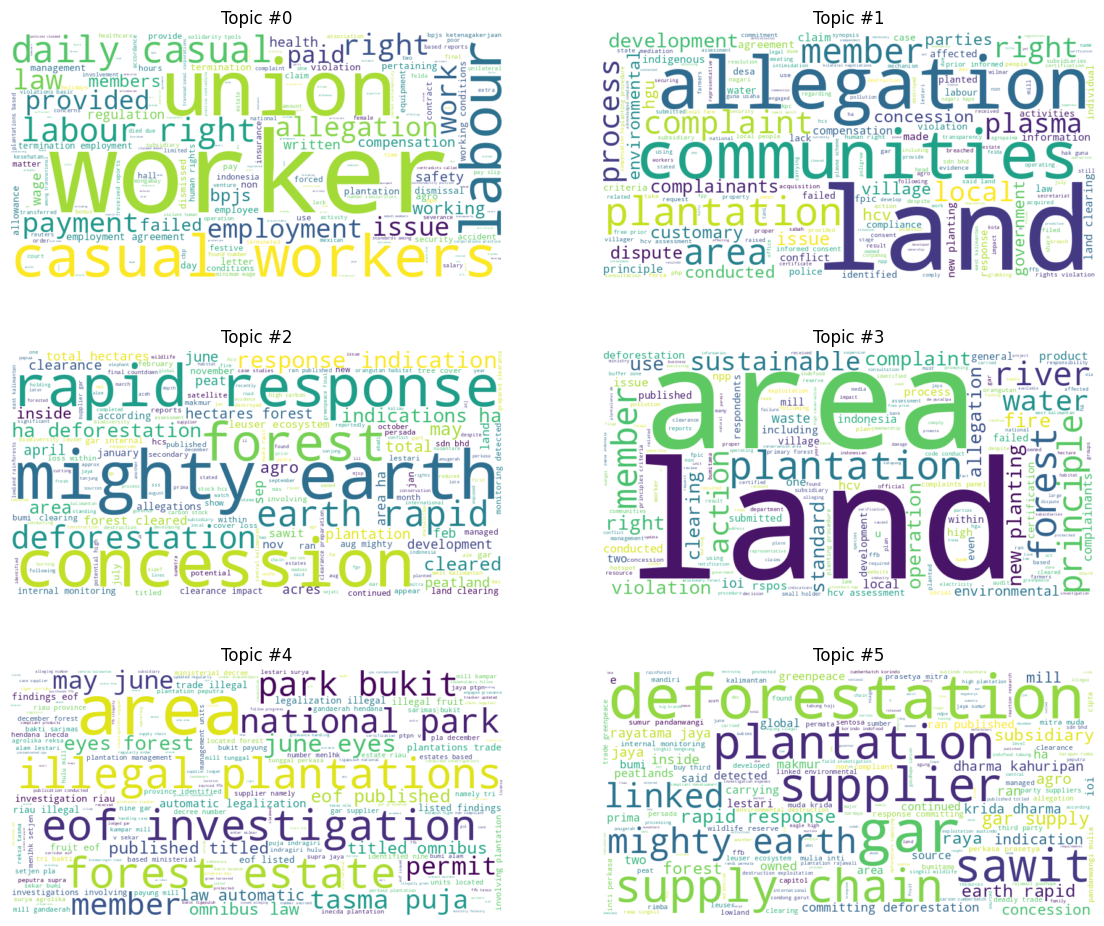

In [28]:
# Input: Receives dataframe containing all rows with classification, table title, and number of topics
# Output: Displays n word clouds
def display_wordcloud(df, title, n_topics):

  n_cols = 2
  n_rows = int(np.ceil(n_topics / n_cols))
  fig = plt.figure(figsize=(14, 4 * n_rows))

  for topic in range(n_topics):
    topic_df = dominant_topic_df[dominant_topic_df['Dominant_Topic'] == topic]
    text = ' '.join(topic_df['Text'].astype(str).tolist()) # Joining the words of each text of each row into a list separated by ' '
    text = re.sub(r'[^A-Za-z\s]', '', text) # Substituting/deleting anything that IS NOT a letter Aa-Zz with ''
    text = text.lower()
    # Fix: Convert words_to_filter set to a list before concatenation
    en_stop = set(stopwords.words('english') + list(words_to_filter))
    text = ' '.join(word for word in text.split() if word not in en_stop)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    ax = fig.add_subplot(n_rows, n_cols, topic + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Topic #{topic}")
    ax.axis("off")

  fig.suptitle(title, fontsize=32)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()


display_wordcloud(df=dominant_topic_df, title='Topic Classification Wordclouds', n_topics=10)

## Dominant Topic Frequency

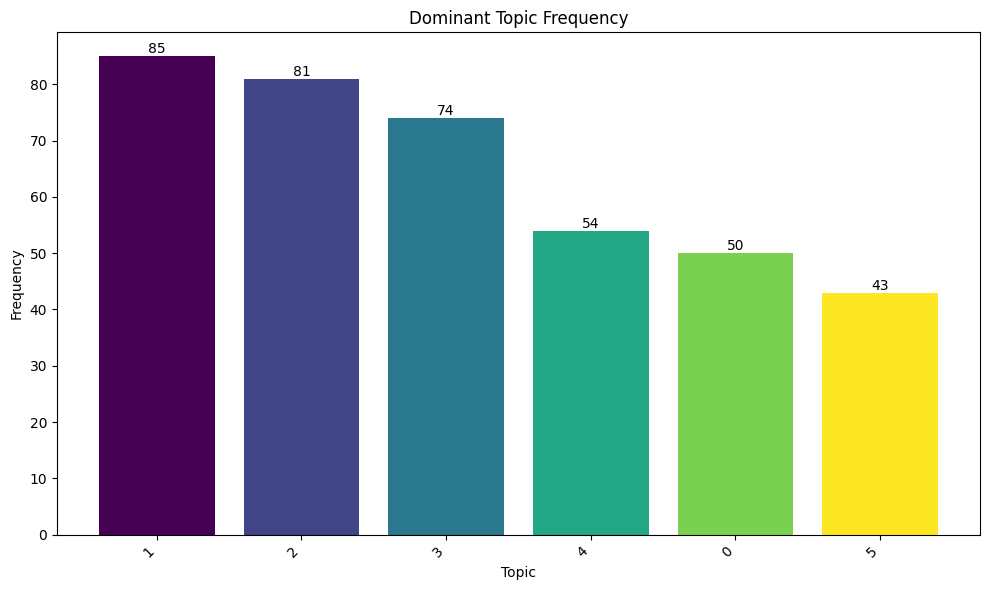

In [29]:
import matplotlib.pyplot as plt
import numpy as np # Import numpy if not already imported

# Ensure dominant_topic_df is available
if  'dominant_topic_df' not in locals():
    print("Error:  dominant_topic_df' not found. Please run the cell that creates dominant_topic_df first.")
else:
    #https://colab.research.google.com/drive/1jQiYlqZ7jpm4bk9UP0JvYhVLkcXenWPF?authuser=1#scrollTo=Overall_Dominant_Topic_Share
    # Calculate topic share (frequency) from dominant_topic_df
    df_topic_share = dominant_topic_df.groupby(['Dominant_Topic'])['Document_Num'].count().reset_index()
    df_topic_share.columns = ['Topic', 'Frequency'] # Rename columns for clarity

    # Sort by frequency to potentially make the plot more informative
    df_topic_share = df_topic_share.sort_values('Frequency', ascending=False)


    # Define colors (optional, adjust as needed based on number of topics)
    # Ensure the number of colors matches the number of topics to display
    num_topics_to_plot = len(df_topic_share)
    # You can use a colormap to generate enough colors
    colors = plt.cm.viridis(np.linspace(0, 1, num_topics_to_plot))


    # Create the bar plot
    fig, ax = plt.subplots(figsize=(10, 6)) # Adjust figure size as needed

    # Plot the bars
    bars = ax.bar(df_topic_share['Topic'].astype(str), df_topic_share['Frequency'], color=colors)

    # Add labels to the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment

    # Set plot title and labels
    plt.title('Dominant Topic Frequency')
    plt.xlabel('Topic')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels if they overlap
    plt.tight_layout() # Adjust layout
    plt.show()

## Topic Distribution per Doc

In [30]:
def topic_dist_doc(df, n_topics, doc_num):
    import matplotlib.pyplot as plt

    topics = []
    values = []

    doc_row = df[df['Document_Num'] == doc_num]

    for i in range(n_topics):
        col_name = f"Topic_{i}_Perc"
        val = doc_row[col_name].values[0] if not doc_row.empty and pd.notnull(doc_row[col_name].values[0]) else 0.0
        topics.append(col_name)
        values.append(float(val))  # Ensure it's a float

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(topics, values, color='red')
    plt.xlabel('Topics')
    plt.ylabel('Topic Contribution')
    plt.title(f'{model_name} - Topic Distribution for Document {doc_num}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
doc_number = 3    # Change This
topic_dist_doc(dominant_topic_df, number_of_topics, doc_num=doc_number)

## Overall Dominant Topic % Share

In [ ]:
# Ensure dominant_topic_df is available
if 'dominant_topic_df' not in locals():
    print("Error: 'dominant_topic_df' not found. Please run the cell that creates dominant_topic_df first.")
else:
    # Plot a histogram of the 'Topic_%_Contrib' column from dominant_topic_df
    dominant_topic_df['Topic_%_Contrib'].plot(kind='hist', bins=20, title='Dominant Topic % Contribution', color="green")
    plt.gca().spines[['top', 'right',]].set_visible(False)
    plt.xlabel('Dominant Topic % Contribution')
    plt.ylabel('Frequency')
    plt.show() # Add plt.show() to display the plot

# Scoring Methods

## Topic Coherence Score

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

texts = [doc.split() for doc in df_embeddings['flt_tokens']]
dictionary = Dictionary(texts)

topic_words = [[word for word, _ in bertopic_model.get_topic(i)] for i in range(len(bertopic_model.get_topics())) if i != -1]

coherence_model = CoherenceModel(
    topics=topic_words,
    texts=texts,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_score = coherence_model.get_coherence()
print("Topic Coherence:", coherence_score)


## Topic Diversity

In [ ]:
topic_words = [bertopic_model.get_topic(i) for i in range(len(bertopic_model.get_topics())) if i != -1]
top_words = [word for topic in topic_words for word, _ in topic[:10]]
unique_words = len(set(top_words))
total_words = len(top_words)
diversity = unique_words / total_words
print("Topic Diversity:", diversity)

## Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_score

# Use embeddings and predicted topics (excluding -1)
mask = df_embeddings['topic'] != -1
score = silhouette_score(
    np.vstack(df_embeddings.loc[mask, 'embedding']),
    df_embeddings.loc[mask, 'topic']
)
print("Silhouette Score:", score)

## Davies-Bouldin Index

In [ ]:
from sklearn.metrics import davies_bouldin_score

score = davies_bouldin_score(
    np.vstack(df_embeddings.loc[mask, 'embedding']),
    df_embeddings.loc[mask, 'topic']
)
print("Davies-Bouldin Index:", score)

In [ ]:
dominant_topic_df = format_bertopic_sentences(model=bertopic_model, embeddings=df_embeddings, n_topics=number_of_topics)
display_wordcloud(df=dominant_topic_df, title='Topic Classification Wordclouds (Updated)', n_topics=number_of_topics)

In [ ]:
bertopic_model.visualize_hierarchy()

In [ ]:
hierarchical_topics = bertopic_model.hierarchical_topics(docs)
bertopic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
bertopic_model.visualize_barchart(top_n_topics=20, n_words=8, height=400, width=600)
